<a href="https://colab.research.google.com/github/Usama-alt1/ML/blob/main/Loan_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import shap
import joblib

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [3]:
path = kagglehub.dataset_download("hemanthsai7/loandefault")

print("Path to dataset files:", path)

100%|██████████| 8.72M/8.72M [00:00<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hemanthsai7/loandefault/versions/1


In [4]:
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        csv_file_path = os.path.join(path, filename)
        break  # Stop after finding the first CSV file

print("Path to the found CSV file:", csv_file_path)
df = pd.read_csv(csv_file_path)  # Use the found CSV file path

print("Dataset shape:", df.shape)


Path to the found CSV file: /root/.cache/kagglehub/datasets/hemanthsai7/loandefault/versions/1/train.csv
Dataset shape: (67463, 35)


In [5]:
df.head()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,...,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,...,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,...,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,...,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,...,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


In [6]:
df = df.dropna()

In [7]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [8]:
print(df_encoded.columns.tolist())

['ID', 'Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term', 'Interest Rate', 'Home Ownership', 'Debit to Income', 'Delinquency - two years', 'Inquires - six months', 'Open Account', 'Public Record', 'Revolving Balance', 'Revolving Utilities', 'Total Accounts', 'Total Received Interest', 'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee', 'Collection 12 months Medical', 'Last week Pay', 'Accounts Delinquent', 'Total Collection Amount', 'Total Current Balance', 'Total Revolving Credit Limit', 'Loan Status', 'Batch Enrolled_BAT1135695', 'Batch Enrolled_BAT1184694', 'Batch Enrolled_BAT1467036', 'Batch Enrolled_BAT1586599', 'Batch Enrolled_BAT1761981', 'Batch Enrolled_BAT1766061', 'Batch Enrolled_BAT1780517', 'Batch Enrolled_BAT1930365', 'Batch Enrolled_BAT2003848', 'Batch Enrolled_BAT2078974', 'Batch Enrolled_BAT2136391', 'Batch Enrolled_BAT224923', 'Batch Enrolled_BAT2252229', 'Batch Enrolled_BAT2333412', 'Batch Enrolled_BAT2428731', 'Batch Enrolled_BAT2522922

In [9]:
X = df_encoded.drop('Loan Status', axis=1)
y = df_encoded['Loan Status']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [14]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:59:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [15]:
def evaluate_model(y_test, y_pred, name):
    print(f"--- {name} ---")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")


--- Logistic Regression ---
[[12245     0]
 [ 1248     0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     12245
           1       0.00      0.00      0.00      1248

    accuracy                           0.91     13493
   macro avg       0.45      0.50      0.48     13493
weighted avg       0.82      0.91      0.86     13493

--- Random Forest ---
[[12245     0]
 [ 1248     0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     12245
           1       0.00      0.00      0.00      1248

    accuracy                           0.91     13493
   macro avg       0.45      0.50      0.48     13493
weighted avg       0.82      0.91      0.86     13493

--- XGBoost ---
[[12228    17]
 [ 1247     1]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     12245
           1       0.06      0.00      0.00      1248

    accuracy           

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

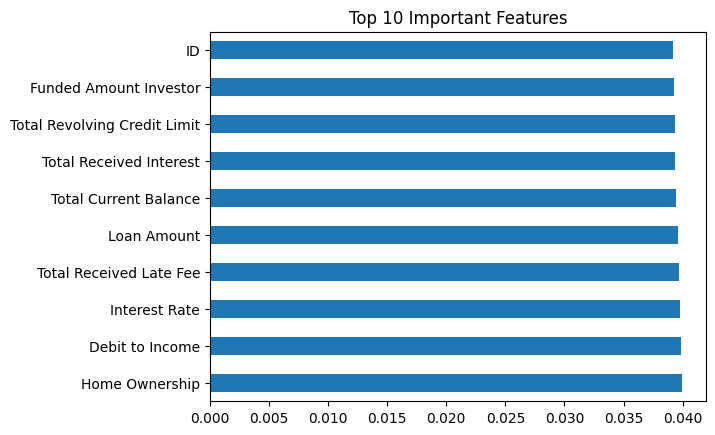

In [16]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()


In [17]:
if 'loan_default' not in df.columns and 'Loan Status' in df.columns:
    df['loan_default'] = df['Loan Status'].apply(lambda x: 1 if x == 'Default' else 0)
    df.drop(columns=['Loan Status'], inplace=True)  # Drop 'Loan Status' after creating 'loan_default'

# Drop unnecessary columns (like ID)
df.drop(columns=['ID'], inplace=True, errors='ignore')  # Ignore error if 'ID' doesn't exist



df_encoded = pd.get_dummies(df, drop_first=True)

# 6. Split features and target
# Assuming 'loan_default' was created earlier and is in df_encoded
X = df_encoded.drop('loan_default', axis=1)
y = df_encoded['loan_default']

print("Class Distribution:\n", y.value_counts())
# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 8. Create pipeline


Class Distribution:
 loan_default
0    67463
Name: count, dtype: int64


In [18]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

In [19]:
pipeline.fit(X_train, y_train)

# 10. Predict
y_pred = pipeline.predict(X_test)
try:
    y_proba = pipeline.predict_proba(X_test)[:, 1]
except IndexError:
    print("Warning: predict_proba only returned probabilities for one class.")
    # If only one class is predicted, adjust accordingly
    y_proba = pipeline.predict_proba(X_test)[:, 0]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13493

    accuracy                           1.00     13493
   macro avg       1.00      1.00      1.00     13493
weighted avg       1.00      1.00      1.00     13493

Confusion Matrix:
 [[13493]]
ROC-AUC Score: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


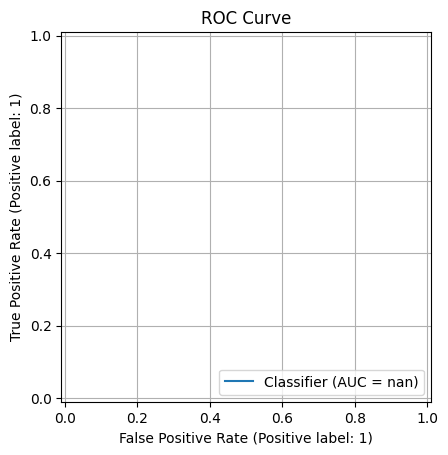

In [20]:
# 11. Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# 12. ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

In [21]:
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
print("Cross-validated ROC-AUC scores:", cv_scores)
print("Mean ROC-AUC:", np.mean(cv_scores))

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_response.py", line 217, in _get_response_values
    y_pred = _process_predict_proba(
             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_response.py", line 54, in _pro

Cross-validated ROC-AUC scores: [nan nan nan nan nan]
Mean ROC-AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_response.py", line 217, in _get_response_values
    y_pred = _process_predict_proba(
             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_response.py", line 54, in _pro

In [22]:
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best Score: nan


In [23]:
joblib.dump(pipeline, "loan_default_model.pkl")

['loan_default_model.pkl']


📌 Random Forest Insights

🎯 Target Distribution:
loan_default
0    13493
Name: count, dtype: int64

🧠 Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13493

    accuracy                           1.00     13493
   macro avg       1.00      1.00      1.00     13493
weighted avg       1.00      1.00      1.00     13493



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


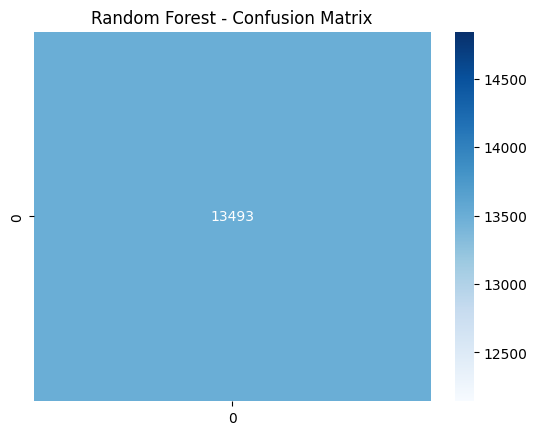

Length of feature_importances: 219
Length of feature_names: 218


In [26]:
def quick_insights(df, y_test, y_pred, model_name="Model", feature_importances=None, feature_names=None): # add feature_names as argument
    print(f"\n📌 {model_name} Insights")

    # Target distribution
    print("\n🎯 Target Distribution:")
    print(y_test.value_counts())

    # Classification Report
    print("\n🧠 Performance:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='d')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # Feature Importance (Optional)
    if feature_importances is not None and feature_names is not None: # Check if both are not None
        if len(feature_importances) != len(feature_names):
            print(f"Warning: Feature importances and feature names have different lengths. Skipping feature importance plot.")
            print(f"Length of feature_importances: {len(feature_importances)}")
            print(f"Length of feature_names: {len(feature_names)}")
            return # Exit function early if mismatch is detected
        else:  # Proceed with plotting only if lengths match
            pd.Series(feature_importances, index=feature_names).nlargest(10).plot(kind='barh')  # use feature_names for index
            plt.title("Top 10 Features")
            plt.show()

# Example usage:
quick_insights(df, y_test, y_pred_rf, "Random Forest", rf.feature_importances_, X.columns) # use X.columns or X_train.columns based on what rf was trained with